## Imports and other boilerplate code

In [1]:
!pip install pytorch-lightning
!rm -rf fx_forecast
!git clone https://github.com/RaghavendraGaleppa/fx_forecast.git

Cloning into 'fx_forecast'...
remote: Enumerating objects: 448, done.
remote: Counting objects: 100% (448/448), done.
remote: Compressing objects: 100% (315/315), done.
remote: Total 448 (delta 274), reused 303 (delta 129), pack-reused 0
Receiving objects: 100% (448/448), 15.57 MiB | 3.87 MiB/s, done.
Resolving deltas: 100% (274/274), done.


In [2]:
from fx_forecast import tools

In [3]:
WINDOW_SIZE = 10
TO_CATEGORICAL = False

In [4]:
price_data, price_labels = tools.build_dataset(
    'fx_forecast/data/DAT_MT_EURUSD_M1_2020.csv',
    'fx_forecast/data/DAT_MT_EURUSD_M1_202101.csv',
    'fx_forecast/data/DAT_MT_EURUSD_M1_202102.csv',
    'fx_forecast/data/DAT_MT_EURUSD_M1_202103.csv',
    'fx_forecast/data/DAT_MT_EURUSD_M1_202104.csv',
    window_size=WINDOW_SIZE,
    to_categorical=TO_CATEGORICAL
)

100%|██████████| 16619/16619 [00:04<00:00, 3569.17it/s]


In [5]:
(X_train, y_train), (X_test, y_test) = tools.split_train_test(price_data, price_labels, split_pct=0.95)

Using split_pct of 0.95
Train data shape: (444279, 10, 1), (444279,)
Test data shape: (23384, 10, 1), (23384,)


In [8]:
import tensorflow as tf

In [9]:
if TO_CATEGORICAL is True:
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
X_train.shape, y_train.shape

((444279, 10, 1), (444279,))

In [11]:
X_test.shape, y_test.shape

((23384, 10, 1), (23384,))

## Model Training

In [19]:
from fx_forecast import models
from importlib import reload
reload(models)

<module 'fx_forecast.models' from '/content/fx_forecast/models.py'>

In [20]:
model = models.cnn_lstm_model(input_shape=(WINDOW_SIZE,1), num_classes=1)
model.compile(loss='mse',optimizer='adam')
checkpoint_filepath = f'CNNLSTMModel_{WINDOW_SIZE}_1_epochs_300.pth'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 10, 64)            256       
_________________________________________________________________
batch_normalization_12 (Batc (None, 10, 64)            256       
_________________________________________________________________
activation_12 (Activation)   (None, 10, 64)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 10, 64)            12352     
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 64)            256       
_________________________________________________________________
activation_13 (Activation)   (None, 10, 64)           

In [21]:
model.fit(
    X_train, 
    y_train, 
    batch_size=128, 
    validation_data=(X_test, y_test), 
    epochs=10, 
    callbacks=[model_checkpoint_callback]
    )

Epoch 1/10
3110/3471 [=========================>....] - ETA: 20s - loss: 0.3362

KeyboardInterrupt: ignored

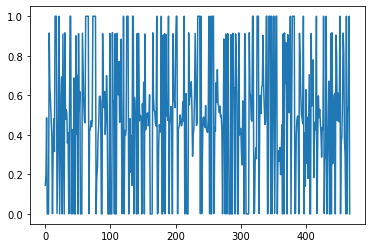

In [ ]:
out = model.predict(X_test)
predicted_output = X_test[:,-1,:].reshape(-1) < out.reshape(-1)
real_output = X_test[:,-1,:].reshape(-1) < y_test.reshape(-1)

from sklearn.metrics import accuracy_score
accuracy_score(y_true=real_output, y_pred=predicted_output)

In [ ]:
from google.colab import files
files.download('CNNLSTMModel_6_1_epochs_300.pth.data-00000-of-00001')
files.download('CNNLSTMModel_6_1_epochs_300.pth.index')

FileNotFoundError: ignored